**Material Didático - Disciplina 0440221 - Geoprocessamento (2025)**
**Professores: André Negrão, Daniel Santos, Luizemara Szameitat**

# Imagens de satélite: obtenção de dados e montar mosaico


OBJETIVO: Exercitar a busca e obtenção de imagens para uso em sensoriamento remoto para diversos fins.

- Nesta versão de código, não é possível executar para as bandas todas de uma vez pelo risco de exceder a memória do Colab. Então é preciso executar para 1 banda, e se precisar de mais, reconfigurar o código para a próxima banda.



*Editor: Luizemara Szameitat - lszameitat.com - contato@lszameitat.com - 2025*

![Banner USP](https://raw.githubusercontent.com/lszam/geofex/main/assets/img/banner_usp.png)


# 1. Instalar pacotes no ambiente

In [42]:
!apt-get install -y gdal-bin

!pip install pystac_client planetary_computer rasterio geopandas matplotlib tqdm -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Importar pacotes que serão usados

In [43]:
from datetime import datetime
from pystac_client import Client
import planetary_computer as pc
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from shapely.geometry import shape, Polygon
import matplotlib.pyplot as plt

import os
import requests

from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
import matplotlib.pyplot as plt
import glob

from rasterio.enums import Resampling

# 2. Selecionar imagens

**Escolha aqui as coordenadas da área de interesse, AOI (area of interest)**

In [44]:
# 1. Conectar ao catálogo
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# 2. Definir a área de interesse (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [-46.05, -23.35],  # canto sudoeste
        [-45.55, -23.35],  # canto sudeste
        [-45.55, -23.05],  # canto nordeste
        [-46.05, -23.05],  # canto noroeste
        [-46.05, -23.35]   # repetir o primeiro para fechar o polígono
    ]]
}

Existem 5 imagens pré-selecionadas


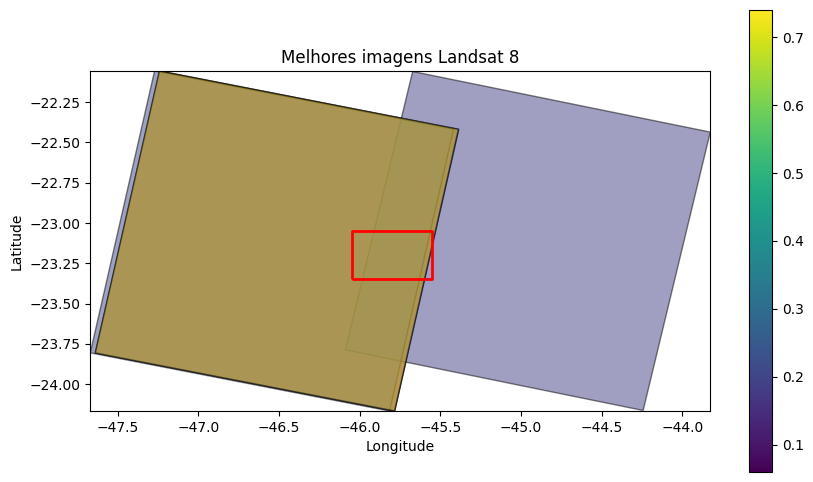

In [45]:
# 3. Buscar imagens Landsat 8 (filtro nuvens e data)
search = catalog.search(
    filter_lang="cql2-json",
    filter={
        "op": "and",
        "args": [
            {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
            {"op": "<", "args": [{"property": "eo:cloud_cover"}, 2]}, # 👈 escolher % de nuvens
            {"op": "=", "args": [{"property": "collection"}, "landsat-8-c2-l2"]},
            {"op": ">", "args": [{"property": "datetime"}, "2020-01-01T00:00:00Z"]},
            {"op": "<", "args": [{"property": "datetime"}, "2022-01-01T23:59:59Z"]}
        ]
    }
)

# 4. Obter e ordenar por menor cobertura de nuvem
items = list(search.items())
items_sorted = sorted(items, key=lambda item: item.properties.get("eo:cloud_cover", 100))

# 5. Selecionar as melhores
best_items = items_sorted[:50] # 👈 escolher número de imagens listadas

print(f"Existem {len(best_items)} imagens pré-selecionadas")

# 6. Gerar GeoDataFrame dos footprints
geoms = [shape(item.geometry) for item in best_items]
gdf = gpd.GeoDataFrame({
    "cloud_cover": [item.properties["eo:cloud_cover"] for item in best_items],
    "datetime": [item.properties["datetime"] for item in best_items]
}, geometry=geoms, crs="EPSG:4326")

# 7. AOI como GeoDataFrame
aoi_geom = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:4326")

# 8. Plotar localização das imagens encontradas, cores para o "cloud_cover"
fig, ax = plt.subplots(figsize=(10, 6))
# Plotar localização das imagens
gdf.plot(ax=ax, column="cloud_cover", legend=True, cmap="viridis", alpha=0.5, edgecolor='black')
# Plotar a área de interesse (AOI)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
# Definir os limites do gráfico manualmente com base na geometria
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

plt.title("Melhores imagens Landsat 8")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




Verificar como as imagens se sobrepõem para evitar redundância

In [46]:
# Reprojetar para UTM 23S (projeção métrica em metros)
gdf_proj = gdf.to_crs("EPSG:31983")

# Calcular área no CRS projetado (em m²)
gdf_proj["area"] = gdf_proj.geometry.area

# Identificar quais imagens manter
keep_indexes = []

for i, geom_i in enumerate(gdf_proj.geometry):
    to_keep = True
    for j in range(i):
        geom_j = gdf_proj.geometry[j]
        intersection = geom_i.intersection(geom_j)
        if intersection.is_empty:
            continue
        overlap_ratio = intersection.area / geom_i.area
        if overlap_ratio > 0.30:  # 👈 escolher taxa de sobreposição
            to_keep = False
            break
    if to_keep:
        keep_indexes.append(i)

# Filtrar as imagens não redundantes
gdf_reduzido = gdf.iloc[keep_indexes].copy()
print(f"{len(gdf_reduzido)} imagens mantidas de {len(gdf)} após remover sobreposições")

print("Exibir gráfico com imagens mantidas")

# Garantir que o GeoDataFrame das imagens reduzidas está no mesmo CRS da AOI
gdf_reduzido = gdf_reduzido.to_crs("EPSG:4326")
aoi_gdf = aoi_gdf.to_crs("EPSG:4326")


2 imagens mantidas de 5 após remover sobreposições
Exibir gráfico com imagens mantidas


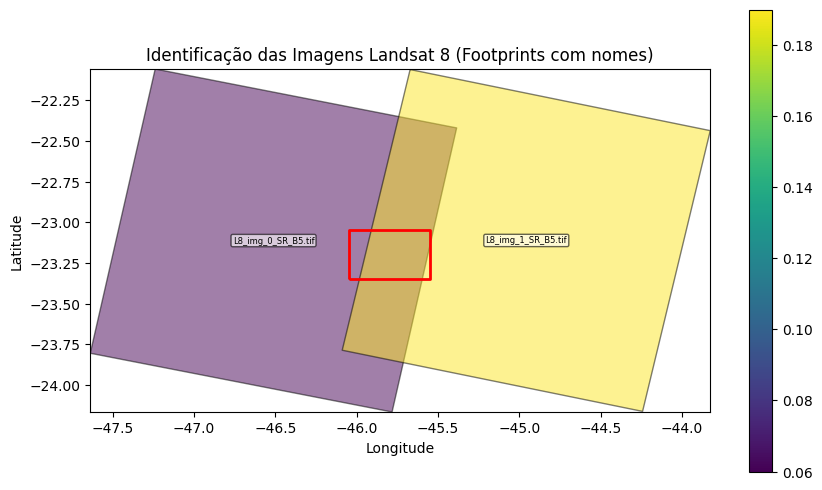

In [47]:
# Plotar os footprints mantidos

gdf_reduzido = gdf_reduzido.copy()
gdf_reduzido["filename"] = [f"L8_img_{i}_SR_B5.tif" for i in range(len(gdf_reduzido))]

fig, ax = plt.subplots(figsize=(10, 6))

gdf_reduzido.plot(ax=ax, column="cloud_cover", legend=True, cmap="viridis", alpha=0.5, edgecolor='black')
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

for idx, row in gdf_reduzido.iterrows():
    centroid = row.geometry.centroid
    label = row["filename"]
    ax.text(centroid.x, centroid.y, label, fontsize=6, ha='center', va='center', color='black',
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

xmin, ymin, xmax, ymax = gdf_reduzido.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

plt.title("Identificação das Imagens Landsat 8 (Footprints com nomes)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# 3. Baixar imagens selecionadas

In [48]:
# Pasta para salvar os arquivos
os.makedirs("/content/landsat", exist_ok=True)



# ===================== Baixar os itens de gdf_reduzido =====================

# Padronizar as datas para comparar imagens da mesma época
datetimes_reduzidas = set(pd.to_datetime(gdf_reduzido["datetime"]).dt.strftime("%Y-%m-%dT%H:%M:%S"))

# Selecionar apenas os itens com datetime correspondente
selected_items = [
    item for item in best_items
    if pd.to_datetime(item.properties["datetime"]).strftime("%Y-%m-%dT%H:%M:%S") in datetimes_reduzidas
]


# Baixar cada item
for i, item in enumerate(selected_items):
    signed = pc.sign_item(item)

    for band_name, asset in signed.assets.items():
        # Aqui baixamos apenas a banda B5 - remover este if se quiser o
        # conjunto completo de bandas, mas no Colab pode haver problemas pela
        # limitação de memórias. para execução em sala de aula, vamos manter
        # o download de 1 banda!

        if band_name == "SR_B5": # 👈 ************************* BANDA ESCOLHIDA
            url = asset.href
            out_path = f"/content/landsat/L8_img_{i}_{band_name}.tif"

            if not os.path.exists(out_path):
                print(f"Baixando {band_name} da imagem {i}...")
                r = requests.get(url, stream=True)
                with open(out_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)


Vamos verificar a resolução espacial utilizando uma das imagens:

In [49]:
print("Spatial resolution: ", rasterio.open("/content/landsat/L8_img_0_SR_B5.tif").res)

Spatial resolution:  (30.0, 30.0)


É bom verificar visualmente se as imagens escolhidas estão sem erros antes de mosaicar, então vamos exibir

Exibindo /content/landsat/L8_img_0_SR_B5.tif...


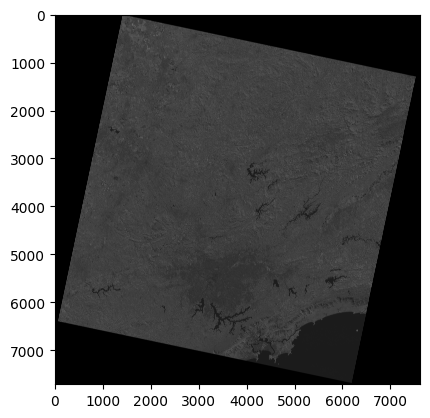

Exibindo /content/landsat/L8_img_1_SR_B5.tif...


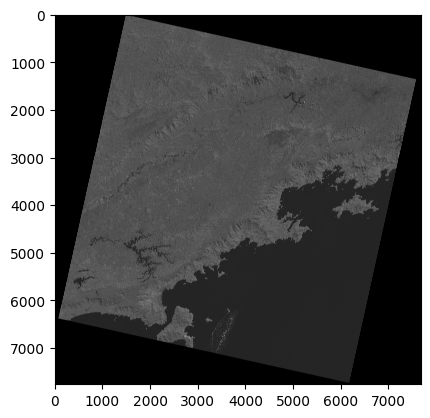

In [50]:
# Exibir imagens selecionadas e baixadas
from rasterio.plot import show

image_files = glob.glob("/content/landsat/*.tif")

for image_file in image_files:
    try:
        with rasterio.open(image_file) as src:
            image = src.read(1)  # 👈 lendo a primeira banda (única, neste caso!)
            print(f"Exibindo {image_file}...")
            show(image, cmap='gray')
    except Exception as e:
        print(f"Erro na exibição de {image_file}: {e}")


# 4. Mosaico

In [51]:
# Verificar se todas as imagens estão com o mesmo sistema de coordenadas
b5_paths = sorted(glob.glob("/content/landsat/*SR_B5.tif"))

for path in b5_paths:
    with rasterio.open(path) as src:
        print(f"{os.path.basename(path)} → {src.crs}")

L8_img_0_SR_B5.tif → EPSG:32623
L8_img_1_SR_B5.tif → EPSG:32623


Como há CRSs diferentes, é preciso padronizar para unir

1 - Reprojetar todos para EPSG:4326 e salvar

2 - Fazer o mosaico com os arquivos já reprojetados

In [52]:
# Pasta para arquivos reprojetados
os.makedirs("/content/landsat_reproj", exist_ok=True)

dst_crs = "EPSG:31983"  # reprojetar

for path in b5_paths:
    with rasterio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        dst_path = f"/content/landsat_reproj/{os.path.basename(path)}"
        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


🪄 **Fazer o mosaico** - Uso da biblioteca gdal. A bib rasterio possui o módulo "merge", mas consome muita memória RAM e pode travar no Colab. Além disso, este modo resolve em uma linha de código, acaba sendo mais prático!**

In [53]:
!gdal_merge.py -o /content/mosaico_b5.tif -of GTiff /content/landsat_reproj/*.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


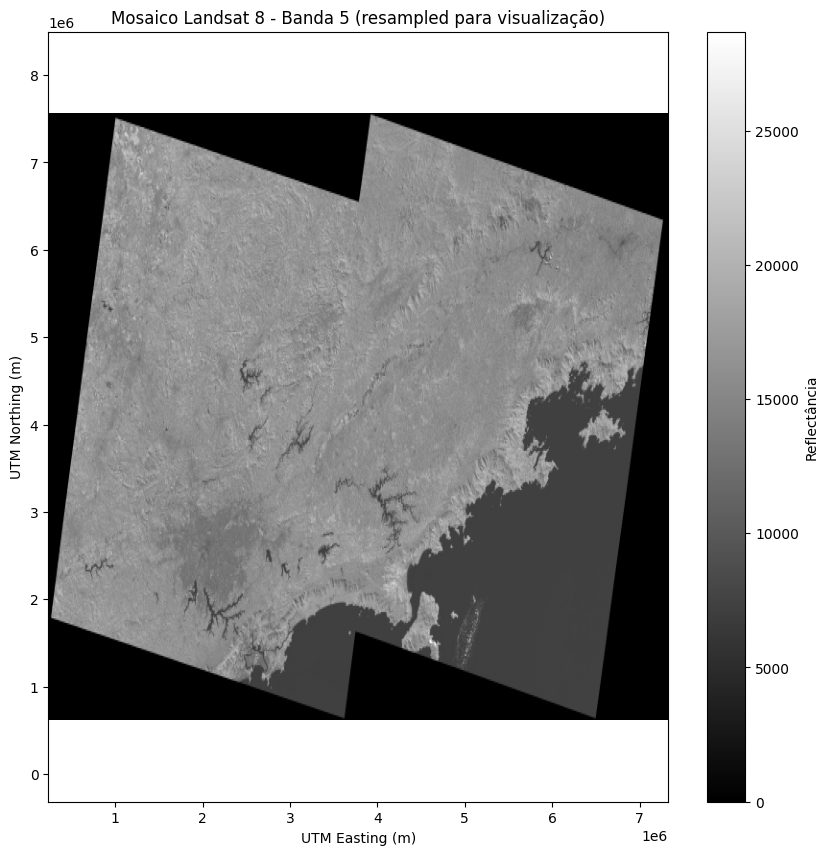

In [54]:
'''
Este jeito travou por falta de memória!

with rasterio.open("/content/mosaico_b5.tif") as src:
    data = src.read(1)
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap="gray", extent=src.bounds)
    plt.title("Mosaico Banda 5 (feito com gdal_merge)")
    plt.colorbar(label="Reflectância")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
'''

# Abrir o mosaico salvo com menor resolução para preservar a memória RAM
with rasterio.open("/content/mosaico_b5.tif") as src:
    # Definir fator de escala (quanto maior, menor a resolução exibida)
    scale = 20    # 👈 escala de exibicao = 1/scale

    # Novo tamanho da imagem reduzida
    new_height = src.height // scale
    new_width = src.width // scale

    # Fazer o resampling da imagem
    data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )

    # Obter os novos limites (extent) da imagem reduzida
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    bounds = rasterio.transform.array_bounds(new_height, new_width, transform)

# Plotar a imagem com segurança
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap="gray", extent=bounds)
plt.title("Mosaico Landsat 8 - Banda 5 (resampled para visualização)")
plt.colorbar(label="Reflectância")
plt.axis('equal')
plt.xlabel("UTM Easting (m)")
plt.ylabel("UTM Northing (m)")
plt.show()


Quando várias imagens Landsat são unidas, cada uma pode ter níveis diferentes de refletância. Isso pode acontecer por diferenças na iluminação solar (data/hora), ângulo do sensor, atmosfera (mesmo com correção), ou ser algum efeito gerado por diferenças radiométricas, por exemplo.

Por isso, as imagens possuem um "brilho" diferente...


## Teste 1:
**📈 Aplicar correção por "stretch" de valores dentro de um intervalo (percentil 2-98). Aplicado nos arquivos de imagens reprojetados, usando valores globais para equilibrar os tons de cinza**

In [55]:
all_valid_values = []

for path in sorted(glob.glob("/content/landsat_reproj/*.tif")):
    with rasterio.open(path) as src:
        band = src.read(1).astype("float32")
        valid = band[np.isfinite(band) & (band > 0)]
        all_valid_values.append(valid)

# Concatenar todos os arrays válidos
all_values = np.concatenate(all_valid_values)

# Calcular percentis globais
global_p2, global_p98 = np.percentile(all_values, (2, 98))
print(f"Percentis globais: P2 = {global_p2}, P98 = {global_p98}")

Percentis globais: P2 = 7163.0, P98 = 21108.0


In [56]:
import os

output_folder = "/content/landsat_stretched_global"
os.makedirs(output_folder, exist_ok=True)

for path in sorted(glob.glob("/content/landsat_reproj/*.tif")):
    with rasterio.open(path) as src:
        band = src.read(1).astype("float32")
        stretched = np.clip((band - global_p2) / (global_p98 - global_p2), 0, 1)

        meta = src.meta.copy()
        meta.update({
            "dtype": "float32",
            "nodata": 0
        })

        out_path = os.path.join(output_folder, os.path.basename(path))
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(stretched, 1)


In [57]:
# Novos valores minimos e máximos das imagens
all_valid_values = []

for path in sorted(glob.glob("/content/landsat_stretched_global/*.tif")):
    with rasterio.open(path) as src:
        band = src.read(1).astype("float32")
        valid = band[np.isfinite(band) & (band > 0)]
        all_valid_values.append(valid)

all_values = np.concatenate(all_valid_values)
new_p2, new_p98 = np.percentile(all_values, (2, 98))
print(f"Percentis globais: P2 = {new_p2}, P98 = {new_p98}")

Percentis globais: P2 = 0.002940121805295348, P98 = 1.0


🪄 **Fazer o mosaico**

In [58]:
!gdal_merge.py -o /content/mosaico_b5_corr-v1.tif -of GTiff -ot Float32 /content/landsat_stretched_global/*.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


Verificar se os valores estão normalizados (entre 0 e 1)

In [59]:
import rasterio
with rasterio.open("/content/mosaico_b5_corr-v1.tif") as src:
    data = src.read(1)
    print("Min:", data.min(), "Max:", data.max(), "Mean:", data.mean())

Min: 0.0 Max: 1.0 Mean: 0.4010517


🗺️ Exibir o mapa do dado após a correção

CRS do mosaico: EPSG:31983


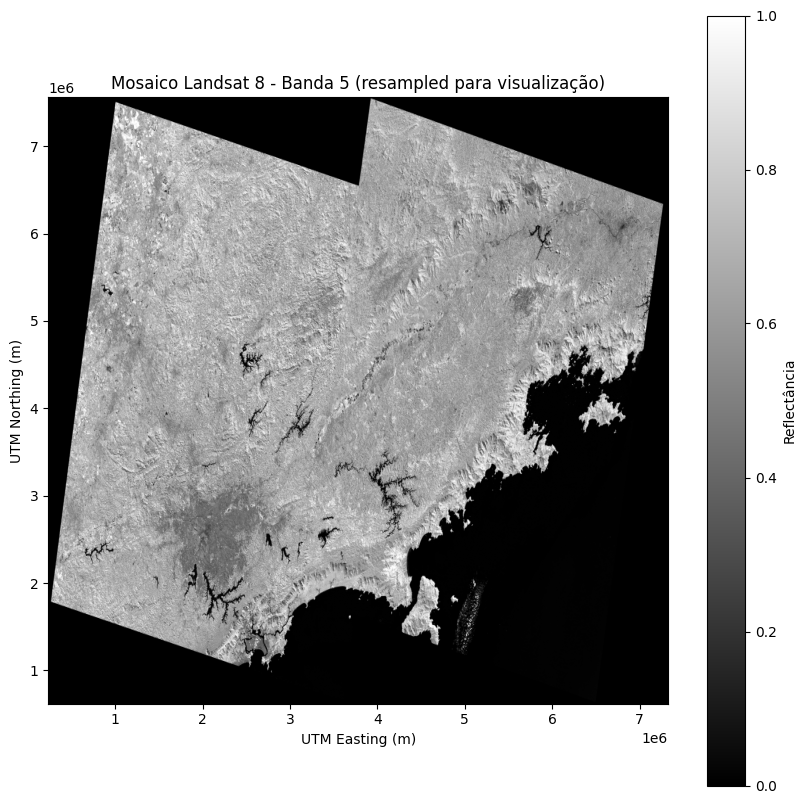

In [60]:
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

# Exibir o mosaico salvo com menor resolução para preservar a memória RAM
with rasterio.open("/content/mosaico_b5_corr-v1.tif") as src:
    # Definir fator de escala (quanto maior, menor a resolução exibida)
    scale = 10

    # Tamanho da imagem reduzida
    new_height = src.height // scale
    new_width = src.width // scale

    # Reamostrar a imagem
    data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )

    # Obter os novos limites (extent) da imagem reduzida
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    bounds = rasterio.transform.array_bounds(new_height, new_width, transform)

# Exibir o CRS
with rasterio.open("/content/mosaico_b5_corr-v1.tif") as src:
    print("CRS do mosaico:", src.crs)

# Plotar
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap="grey", extent=bounds)
plt.title("Mosaico Landsat 8 - Banda 5 (resampled para visualização)")
plt.colorbar(label="Reflectância")
plt.xlabel("UTM Easting (m)")
plt.ylabel("UTM Northing (m)")
plt.show()

## Teste 2:
**📈 Aplicar correção por "stretch" de valores dentro de um intervalo (percentil 2-98). Aplicado nos arquivos de imagens reprojetados, usando valores individuais para equilibrar os tons de cinza**

In [61]:
# Aplicar stretch nos reprojetados, usando percentis (de 2 a 98)

import rasterio
import numpy as np
import os
import glob

in_folder = "/content/landsat_reproj"
out_folder = "/content/landsat_stretched"
os.makedirs(out_folder, exist_ok=True)

# Abre cada raster e executa o filtro por percentis
for path in sorted(glob.glob(f"{in_folder}/*.tif")):
    with rasterio.open(path) as src:
        band = src.read(1).astype("float32")
        valid = band[np.isfinite(band) & (band > 0)]

        if valid.size > 0:
            p2, p98 = np.percentile(valid, (2, 98))
            stretched = np.clip((band - p2) / (p98 - p2), 0, 1)
        else:
            stretched = np.zeros_like(band)

        meta = src.meta.copy()
        meta.update({
            "dtype": "float32",
            "nodata": 0
        })

        out_path = os.path.join(out_folder, os.path.basename(path))
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(stretched, 1)


In [62]:
!gdal_merge.py -o /content/mosaico_b5_corr-v2.tif -of GTiff -ot Float32 /content/landsat_stretched/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [63]:
with rasterio.open("/content/mosaico_b5_corr-v2.tif") as src:
    data = src.read(1)
    print("Min:", np.min(data), "Max:", np.max(data), "Mean:", np.mean(data))

Min: 0.0 Max: 1.0 Mean: 0.40281826


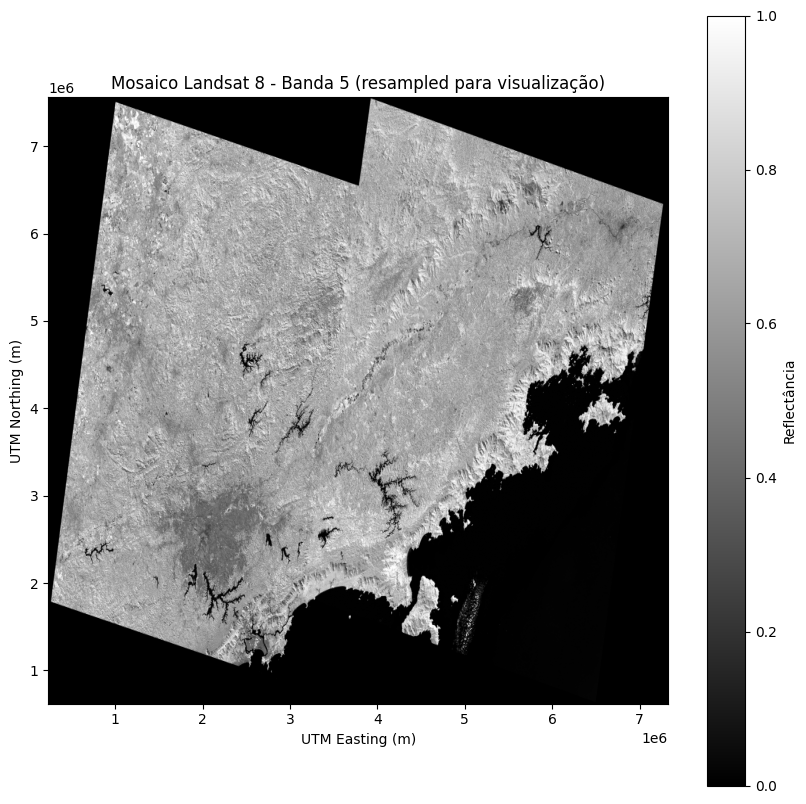

In [64]:
# Exibir o mosaico salvo com menor resolução para preservar a memória RAM
with rasterio.open("/content/mosaico_b5_corr-v2.tif") as src:
    # Definir fator de escala
    scale = 10

    # Tamanho da imagem reduzida
    new_height = src.height // scale
    new_width = src.width // scale

    # Reamostrar a imagem
    data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )

    # Obter os novos limites da imagem reduzida
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    bounds = rasterio.transform.array_bounds(new_height, new_width, transform)

# Plotar
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap="grey", extent=bounds)
plt.title("Mosaico Landsat 8 - Banda 5 (resampled para visualização)")
plt.colorbar(label="Reflectância")
plt.xlabel("UTM Easting (m)")
plt.ylabel("UTM Northing (m)")
plt.show()

**Qual mosaico usar?***

In [65]:
mosaico_escolhido = "/content/mosaico_b5_corr-v1.tif"

# Exibir mosaico escolhido com os estados

In [66]:
!pip install geopandas geobr -q

In [67]:
import geopandas as gpd
from geobr import read_state
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show
from shapely.geometry import box

In [68]:
# Observar e coletar informações do raster

with rasterio.open(mosaico_escolhido) as src:
    print("CRS do raster:", src.crs)
    print("Resolução:", src.res)
    print("Bounds:", src.bounds)
    raster_bounds = src.bounds # limites
    print("Height:", src.height)
    print("Width:", src.width)
    raster_crs = src.crs # sistema de coord do raster

CRS do raster: EPSG:31983
Resolução: (29.999999999643684, 29.999999999643684)
Bounds: BoundingBox(left=231884.9999992625, bottom=7327285.000077475, right=619514.9999946586, top=7560115.00007471)
Height: 7761
Width: 12921


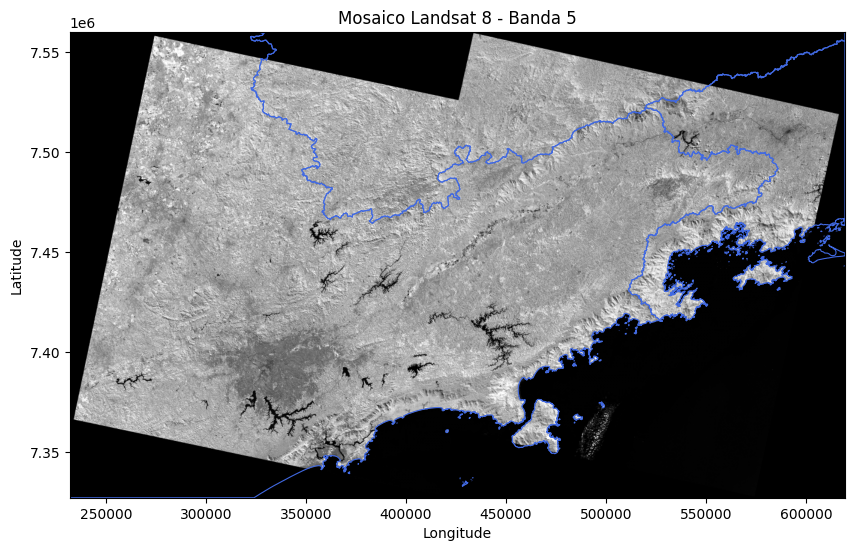

In [69]:
# Carregar UFs do IBGE
ufs = read_state(year=2020)  # SHP vem em EPSG:4674 (lat/lon) !!!
ufs = ufs.to_crs(raster_crs)  # garantir que está igual ao raster

# Criar polígono com a "bounding box" do raster
bbox_geom = box(*raster_bounds)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=raster_crs)

# Garantir que UFs estão no mesmo CRS do mosaico
ufs = ufs.to_crs(raster_crs)

# Recortar as UFs com base na bounding box
ufs_recorte = gpd.clip(ufs, bbox_gdf)

# Plotar resultado com DEM e UFs recortadas
with rasterio.open(mosaico_escolhido) as src:
    scale = 10
    new_height = src.height // scale
    new_width = src.width // scale

    data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )
    new_transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )

# Plotando
fig, ax = plt.subplots(figsize=(10, 10))
show(data, transform=new_transform, ax=ax, cmap="grey")
ufs_recorte.boundary.plot(ax=ax, edgecolor="royalblue", linewidth=0.8)
plt.title("Mosaico Landsat 8 - Banda 5")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Baixar arquivos

In [70]:
from google.colab import files
files.download('/content/mosaico_b5.tif')
files.download('/content/mosaico_b5_corr-v1.tif')
files.download('/content/mosaico_b5_corr-v2.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>